# Vector Add

本教程是 OpenAI Triton 的入门教程之一，主要演示了如何使用 Triton 来实现经典的 GPU 程序：向量加法。

## Vector Add 的 kernel 函数

如下面代码所示，被 `triton.jit` 装饰器装饰的函数 `add_kernel` 是一个 Triton kernel 函数，我们可以把它理解为一个处理一个数据子集的进程。我们在 `add`函数中，会同时启动多个这样的进程，通过一个 `grid` 来定义一个进程组网络。当 `add_kernel` 在 `add` 函数中被调用时，后面会同时启动一个进程网络（一组进程），进程网络中的每个进程分别处理一部分数据。

整个进程网络可以是一维、二维，甚至是三维的。进程网格中的进程，可以通过 `tl.program_id` 来获取自己在整个进程网络中的位置。

In [ ]:
import torch
import triton
import triton.language as tl


# 一个 kernel 函数，映射为一个 cuda thread block，和 cuda c 中的 kernel 函数在一个层次上
@triton.jit
def add_kernel(x_ptr, y_ptr, output_ptr, n_elements, BLOCK_SIZE: tl.constexpr):
    # program_id 应该是指 BlockIdx
    pid = tl.program_id(axis=0)
    # 当前block处理的起始位置
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    # 将数据从 global memory 加载到 cuda core 的寄存器上
    # x_ptr 和 y_ptr 是一个 scalar 地址, offset 是一个 range
    # 所以这里 load 的第一参数是一个 element-wise 的 range
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    tl.store(output_ptr + offsets, output, mask=mask)


def add(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    output = torch.empty_like(x)
    assert x.is_cuda and y.is_cuda and output.is_cuda
    n_elements = output.numel()
    # grid可以是一个Tuple[int]类型，也可能是一个Callable(metaparameters)->Tuple[int]的类型
    grid = lambda meta: (triton.cdiv(n_elements, meta["BLOCK_SIZE"]),)
    # 传入的x, y, output(torch.Tensor类型)会隐式的转换为其第一个元素的指针
    # 被triton.jit装饰的函数，可以通过grid来进行索引，返回一个可调用的gpu kernel
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=1024)
    return output

In [2]:
torch.manual_seed(0)
size = 90432
x = torch.rand(size, device="cuda")
y = torch.rand(size, device="cuda")
output_torch = x + y
output_triton = add(x, y)
print(
    f"The maximum difference between torch and triton is {torch.max(torch.abs(output_torch - output_triton))}"
)

The maximum difference between torch and triton is 0.0


## Triton 的核心数据结构 

在 Triton 中，`tl.tensor` 是 Triton 语言（Triton Language, tl）的核心数据结构，用于表示在 GPU 中执行计算的多维数组（或张量）。它类似于其他深度学习框架中的张量（如 PyTorch 的 torch.Tensor），但专门针对 GPU 上的高性能计算设计。

在 Triton kernel 函数中，我们要操作的数据往往都用 `tl.tensor`来表示。在上面的示例中，我们使用`tl.arange`创建的就是一个 `1-d`的 tensor，同样，`tl.load`接口返回的也是一个 tensor。

tensor 支持多种运算，包括了一些创建操作、形状变换操作、数学运算、归约、SCAN等。我们可以在[Triton 的文档](https://triton-lang.org/main/python-api/triton.language.html)中查看支持的操作列表。



## 编译期常量参数

在 kernel 函数中，我们可以设置一些编译期常量参数，这些编译期常量在编译阶段确定某些值，从而帮助 Triton 优化代码生成、内存布局和其他性能关键的操作。我们把这些参数称为` meta-parameters`。常用的一些编译期常量如下：

* `BLOCK_SIZE_X`, `BLOCK_SIZE_Y`, `BLOCK_SIZE_Z：线程块大小。`
* `NUM_THREADS` / `NUM_WARPS`：控制并行线程数量。
* `STRIDE_X` / `STRIDE_Y`：数据存储步长。
* `GROUP_SIZE`：分组大小。
* `UNROLL_FACTOR`：循环展开因子。
* `DATA_TYPE`：数据类型特化。
* `ALIGNMENT`：内存对齐优化。

## 精度对齐与性能测试

Triton 中提供了一套非常好的用工具，方便我们对实现的 Triton 算子进行性能测试与对比。

装饰器 `triton.testing.perf_report` 用于将一个函数 Mark 为一个 benchmark 函数，随后，我们可以通过`.run`方法来对函数进行测试。

In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["size"],  # 指定横坐标
        x_vals=[2**i for i in range(12, 28, 1)],  # 用于测试的
        x_log=True,
        line_arg="provider",  # 指定纵坐标
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-")],
        ylabel="GB/s",
        plot_name="vector-add-performance",
        args={},
    )
)
def benchmark(size, provider):
    x = torch.rand(size, device="cuda", dtype=torch.float32)
    y = torch.rand(size, device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: x + y, quantiles=quantiles)
    if provider == "triton":
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: add(x, y), quantiles=quantiles
        )
    # 对于 vectorAdd 来说，一个元素对应 8B 的 load 和 4B 的 write
    # 由于我们输入的是毫秒，所以转换为 GB/s 时，需要乘以 1e-6
    gbps = lambda ms: 12 * size / ms * 1e-6
    return gbps(ms), gbps(max_ms), gbps(min_ms)

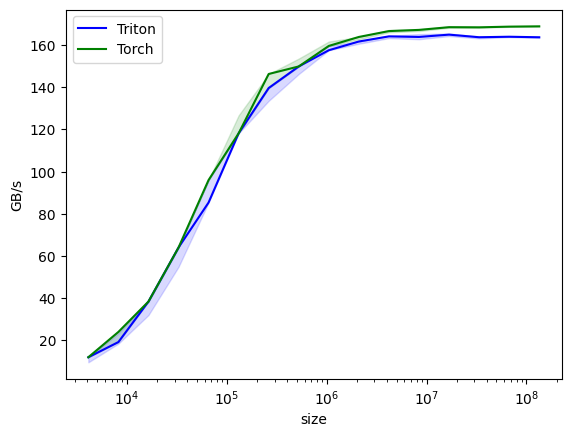

<Figure size 640x480 with 0 Axes>

In [ ]:
benchmark.run(print_data=False, show_plots=True, save_path="")